## Hypothesis Testing

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

## Use hypothesis testing to understan if there any relation between two features

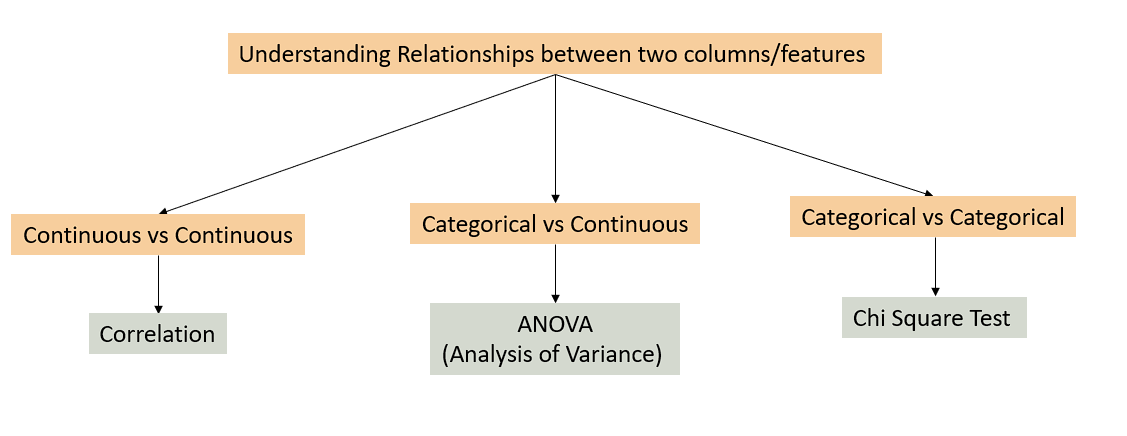

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('tips.csv')
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [6]:
df.isna().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [7]:
df.duplicated().sum()

1

## Seperate cat and con features

In [8]:
cat = list(df.columns[df.dtypes=='object'])
con = list(df.columns[df.dtypes!='object'])

In [9]:
cat

['sex', 'smoker', 'day', 'time']

In [10]:
con

['total_bill', 'tip', 'size']

## Continuous vs continuous - Correlation

In [11]:
df[con].corr()

,total_bill,tip,size
total_bill,1.000000,0.675734,0.598315
tip,0.675734,1.000000,0.489299
size,0.598315,0.489299,1.000000


<Axes: >

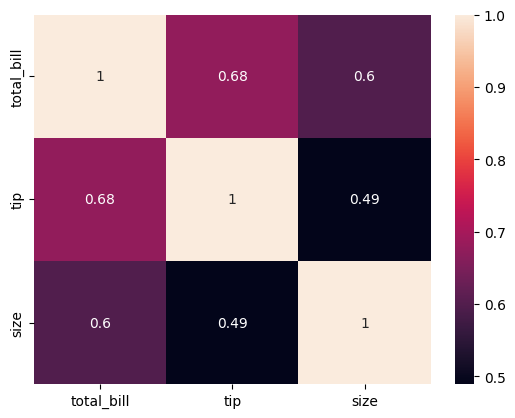

In [12]:
import seaborn as sns
sns.heatmap(df[con].corr(), annot=True)

## Total bill and tip are positively correlated by 68%

## Understanding relationship between categorical vs continuous features - ANOVA (ANalysis Of VAriance)

In [13]:
cat

['sex', 'smoker', 'day', 'time']

In [14]:
con

['total_bill', 'tip', 'size']

## Trying to understan relationship between day and total_bill

In [15]:
from statsmodels.formula.api import ols
model = ols('total_bill~C(day)', df).fit()

In [16]:
from statsmodels.stats.anova import anova_lm
Q = anova_lm(model)
Q

,df,sum_sq,mean_sq,F,PR(>F)
C(day),3.0,643.941362,214.647121,2.767479,0.042454
Residual,240.0,18614.522721,77.560511,NaN,NaN


## if p_value = 0.3 , confidence_level= 1 - p_value = 1-0.3 = 70%
## Two features are dependent on each other only is p_value<0.05 (95% confidence level)

In [17]:
p_value = Q.iloc[0, -1]
p_value

0.04245383328951916

## In above test i can clearly say that p_value <=0.05 hence, Day and Total Bill are dependent on each other.

In [18]:
confidence_level = 1-p_value
confidence_level

0.9575461667104809

## Create a function to get p_value from any two cat and con features

In [19]:
def ANOVA(df, cat_cols, con_cols):
    from statsmodels.formula.api import ols
    from statsmodels.stats.anova import anova_lm
    formula = f'{con_cols}~C({cat_cols})'
    model = ols(formula, df).fit()
    Q = anova_lm(model)
    p_value = round(Q.iloc[0, -1], 4)
    return p_value

In [21]:
ANOVA(df, 'day', 'tip')

0.1736

## In above case p_value is not less than 0.05 , Day and Tip are NOT Dependent on each other

In [22]:
cat

['sex', 'smoker', 'day', 'time']

In [23]:
# Understanding if there is relationship between total_bill and all other cat features
for i in cat:
    p_val = ANOVA(df, i, "total_bill")
    print(f'p_value for {i} vs total_bill : {p_val}')

p_value for sex vs total_bill : 0.0236
p_value for smoker vs total_bill : 0.182
p_value for day vs total_bill : 0.0425
p_value for time vs total_bill : 0.0041


## Total Bill is DEPENDENT on Gender, Day, Time (because p_val<=0.05)
## Total Bill is NOT DEPENDENT on Smoker (because p_val>=0.05)

In [24]:
for i in cat:
    p_val = ANOVA(df, i, "tip")
    print(f'p_value for {i} vs tip : {p_val}')

p_value for sex vs tip : 0.1665
p_value for smoker vs tip : 0.9266
p_value for day vs tip : 0.1736
p_value for time vs tip : 0.0578


## Tip os not dependent on any categorical features(Because of p_value >=0.5)

In [25]:
for i in cat:
    p_val = ANOVA(df, i, "size")
    print(f'p_value for {i} vs size : {p_val}')

p_value for sex vs size : 0.1796
p_value for smoker vs size : 0.0376
p_value for day vs size : 0.0068
p_value for time vs size : 0.1071


## Size is DEPENDENT on Smoker, Day (because p_val<=0.05)
## Size is NOT DEPENDENT on Gender, Time (because p_val>=0.05)

## Categorical vs Categorical features - Chi Squared test

In [26]:
ctab = pd.crosstab(df['day'], df['time'])

In [27]:
ctab

time,Dinner,Lunch
day,,
Fri,12,7
Sat,87,0
Sun,76,0
Thur,1,61


In [28]:
from scipy.stats import chi2_contingency
chi = chi2_contingency(ctab)
chi

Chi2ContingencyResult(statistic=217.1126728434853, pvalue=8.449897551777147e-47, dof=3, expected_freq=array([[13.70491803,  5.29508197],
       [62.75409836, 24.24590164],
       [54.81967213, 21.18032787],
       [44.72131148, 17.27868852]]))

In [31]:
P_val = chi[1]

In [32]:
P_val = round(chi[1])

In [33]:

P_val

0

## Because p_value is less than 0.05 there is strong relationship between day and time

In [38]:
def chi_square(df, cat_col1, cat_col2):
    ctab = pd.crosstab(df[cat_col1], df[cat_col2])
    from scipy.stats import chi2_contingency
    chi = chi2_contingency(ctab)
    P_val = round(chi[1], 4)
    return P_val

In [39]:
chi_square(df, 'sex', 'smoker')

1.0

## No relation between sex and smoker because p_val>0.5